![](../images/DSC_LOGO_RGB_FULL_COLOUR_2019.png)

# Like Needles in a Haystack: Detecting Truck volumes on Roads in Namibia using Imbalanced Classification


### Loading packages

In [1]:
## THIRD PARTY
import re
import os
import random
import numpy as np
import pandas as pd
import pickle
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import interp

In [2]:
## PROJECT
from truck_detection.chip_process import *

## Table of Contents

<a href="#Introduction"><font size="+0.5">Introduction</font></a>
* Sentinel-2 data
* Derived features
* Classification refresher

<a href="# Load-and-prepare-training-data"><font size="+0.5">Load and prepare training data</font></a>
* Which locations
* Which features

<a href="#Model-Fitting"><font size="+0.5">Model Fitting</font></a>
* Number of trees in RF
* Class balance in training set
* Feature scaling
* Classifier type
* Fit and save model
* Use model to make predictions with chipped data

<a href="#Model-Evaluation"><font size="+0.5">Model Evaluation</font></a>
* Precision
* Recall
* Stratefied K-fold cross validation
* PR curves & AUC


# Introduction

The Namibia Statistics Agency (NSA) wants to estimate economic activity in a more timely manner, improving on their quarterly and monthly estimates of GDP by including novel data sources such as satellite data.

Volumes of traffic running to and from major cities are an important measure of economic activity in a country, and open-source images taken by the European Space Agency's Sentinel-2 (S2) satellite could offer an inexpensive and scalable method for estimating road traffic volumes to be used in economic modelling & policy making. 

As part of the Faster Economic Indicators project, we have coded our own protype process to classify trucks on major roads using S2 data. This process exploits the temporal offset in blue green & red light from large vehicles on a motorway, which is seen as sequence of coloured pixels against the background in the S2 images.  

<h5><center> Figure 1: The 'truck effect' in multispectral S2 mission data. </center></h5>
<img src="./images/sentinel_2_truck_offset.png" width=500 height=500> 

## Sentinel Data 

- The Sentinel 2 (10 m resolution) imagery is freely available with a new image every 5 to 10 days. 

- We extract four image bands for our specified area & date range: blue, green, red & cloud probability.

- The images are extracted via Google Earth Engine, using a shapefile of the road from open street map to mask out non-road pixels and the cloud probability band to mask out pixels above a specified threshold of cloud probability. 

- In QGIS, we manually labelled trucks to use in the model evaluation stage. This was highly time consuming, and in some locations the 'truck effect' was far less discernable than others due to differences in background colour, brightness and cloudiness

## Derived Features

As well as using the single colour image bands as features, we engineered an additional set of features to maximize the classification algorithms ability to discern truck from non-truck in each pixel. You will be using these to fit a classification model for the Windhoek images from S2.

### Colour ratio bands

The absolute colour of the truck pixels change across time and space due to variability in weather, seasonality & terrain so we reasoned that rather than focus on absolute colour values, it would be more instructive to use the relative colour values (ie the ratio of red to green rather than red value). 

<h5><center> Figure 2: Colour ratio features of pixels</center></h5>
<img src="./images/relative_colour.png" width=600 height=600> 

### Deviations from a temporal mean

We wanted a variable to capture the colour of a truck pixel relative to the mean colour over all dates in that pixel location. 

To do this we created a composite mean image from all rasters in the time series, and subtracted the temporal mean values for each feature from the feature values in a specific date. 

Finally we calculate a Z-score for each pixel within the date minus temporal mean image:

$$ Z = \frac{x - \mu}{\sigma} $$

Where $x$ is the subtracted pixel val - the resulting image after subtracting temporal mean image from date image, $\mu$ is that date's subtracted image mean pixel value and $\sigma$ is that date's subtracted pixel image std dev. Some images can be much brighter or darker across the time series, so without the Z score calculated in this way, all pixels in an image at a given date could be much higher or lower than the temporal mean and therefore not a useful measure to highlight the trucks.

<h5><center> Figure 3: Temporal features of pixels</center></h5>
<img src="./images/temporal_diff.png" width=600 height=600> 
<img src="./images/z_score.png" width=500 height=500> 

### Values from neighbouring pixels

A crucial property of the truck effect is that the blue, green and red pixels are connected within a limited kernel space of a few pixels, so we created a feature which extended a small kernel from each pixel and recorded the most green and the most red pixel. 

We then elaborated this to look for max R:G & G:R Z-scores, thereby capturing the temporal and spatial dimensions of the signal. 

Illustrated example: to find the max R:G & G:R z-scores near each pixel:

1. We expand a kernel of a few pixels outwards from each G:R pixel. 
2. We find the local G:R maxima 
3. create a mask from a small kernel surrounding the max G:R pixel 
4. Use this to mask the R:G layer and find the max R:G value from the unmasked pixels.

<h5><center> Figure 4: Neighbour pixel properties</center></h5>
<img src="./images/neighbours.png" width=600 height=600> 



---
# Classification Refresher

**NB:** For an introduction to classification problems in supervised learning, see the relevant chapter from [the DSC intro to ML in python course](https://github.com/datasciencecampus/DSCA_IntroML_Python), from which this section is adapted.

In classification problems, as the name suggests, we want to classify data into categorical data types or classes. The workflow required for a classification problem is much the same as that for a regression model. We will prepare our data, train a model, evaluate it's performance and improve the model with hyperparameter tuning. 

The difference with classification compared to regression are the ways we are going to measure the performance of our model. We can no longer use the difference between **true** and **predicted** values in the same manner as our targets are now categorical not numeric. 

### Logistic Regression

One of the most powerful classification models is built using the principles of regression discussed in the previous chapter. Fundementally, a logistic regression model calculates the probability that a given data point has a certain label. 
If the probability of having a certain label is above a threshold (given by the distribution of the data) then the model gives the data that label. 

Underlying the logistic regression model is a logistic function, shown below. Instead of fitting a linear model using regression, a logistic function is fitted to the data. The value of the function corresponds to the probability that a data point is in a certain class. This is done using a method called Maximum Likelihood Estimation, which calculates the probability of the data being what it is given a certain model. It then tries different models and selects the one with the highest probability of producing the training data. 

This is what the logistic function looks like mathematically: $$ f(x) = \frac{1}{1+e^{-x}}$$

### Random Forest Classifiers

A random forest classifier is, as the name implies, a collection of decision trees classifiers that each do their best to offer the best output. Because we talk about classification and classes and there's no order relation between 2 or more classes, the final output of the random forest classifier is the mode of the classes.
This means the "winner" class is the one who appears most times in the list of outputs from all the decision trees used.
We all know Machine Learning models are never perfect and that sometimes they offer us incorrect data, especially when the data is sparse or we don't have lots of features we can look at.
But random forests are so far better than decision trees because they use the decisions from an ensemble of trees to figure out what is the final output. And while some decision trees may be wrong indeed, there's a high chance that, using carefully groomed data, most of the trees in the forest will be able to offer a better output.

<h5><center> Figure 6: Diagram of a random decision forest</center></h5>
<img src="./images/Random_forest_diagram_complete.png" width=500 height=500> 


Source: [Wikipedia](https://en.wikipedia.org/wiki/Random_forest#:~:text=Random%20forests%20or%20random%20decision%20forests%20are%20an,or%20mean%2Faverage%20prediction%20%28regression%29%20of%20the%20individual%20trees.)

### Other Supervised ML classifers

There is no shortage of algorithms we can use to make class-based predictions using pre-labelled data. Support Vector Machine (SVM) & Extreme Gradient Boosing (XGBoost) are a couple of examples, but others may be more suitable depending on the problem investigated.


<div class="alert alert-block alert-info">
<b><font size="4">Project objectives:</font></b> <p> The NSA wants to apply this technique to measure changes in truck volumes on the main road running north from the Namibian capital, Windhoek. Use the pre-labelled features data as a training set to fit a classification model which will provide estimates of vehicle counts from 2019 - 2021. You will:
<ul>
   <li> Load in the data and carry out any further preprocessing</li>
   <li> Fit a classifier model to training data</li>
   <li> Use this model to predict truck counts on seperate test data</li>
   <li> Evaluate the predictions of your model</li>
</ul>
</div>


<h5><center> Figure 5: Stretch of motorway running North from Namibias capital, Windhoek</center></h5>
<img src="./images/windhoek_osm.PNG" width=500 height=500> 

Lets create a variable location, which we can update if we want to use new areas of interest

In [3]:
location = "windhoek"

---
# Load and prepare training data 


When preprocessing the data for modelling, think about:

1. Which locations to be included in the training set? Some will be more simillar to the AOI (Windhoek, Namibia) than others which will effect external validity of the model.

2. Which features to include & which to leave out? There isn't one 'right' set of features, but think about whether those included contain useful information for distinguishing the target. Some features may provide no explanatory power. 


In [4]:
# load in the features csv file
features = pd.read_csv("../data/all_training_features.csv")
features

,Unnamed: 0,blue,green,red,bg_change,br_change,gr_change,bg_z,br_z,gr_z,...,green_max_temp5,red_max_temp5,greenblue_max5,redblue_max5,greenblue_max_temp5,redblue_max_temp5,validation,ml_class,date,location
0,168676,1.0536,0.9664,0.9328,1.053600,1.053600,0.349470,1.053600,1.053600,1.865255,...,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,0.0,2019-10-01,nairobi
1,393513,0.0999,0.1226,0.1362,-0.012760,-0.005751,0.539186,-0.666817,-0.270743,1.889493,...,183.0,168.0,195.0,177.0,166.0,193.0,-999.0,0.0,2020-12-14,nairobi
2,394447,0.0954,0.1102,0.1282,0.009269,-0.003518,0.626979,0.125706,-0.203395,1.745019,...,232.0,180.0,183.0,202.0,189.0,195.0,-999.0,0.0,2020-12-14,nairobi
3,240916,0.0974,0.1132,0.1248,0.020912,0.025412,0.615292,-0.077738,-0.506089,1.675483,...,151.0,175.0,191.0,194.0,163.0,186.0,-999.0,0.0,2020-02-28,nairobi
4,325607,0.1118,0.1264,0.1516,0.059210,0.029988,0.532425,2.008714,1.191034,1.809716,...,145.0,195.0,192.0,189.0,177.0,166.0,-999.0,0.0,2020-08-06,nairobi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166964,172502,0.0727,0.0929,0.1001,-0.047373,-0.041153,0.517461,-1.614461,-0.965163,1.605305,...,159.0,156.0,192.0,199.0,140.0,189.0,-999.0,0.0,2019-10-16,nairobi
166965,263075,0.0965,0.1088,0.0972,0.056521,0.164899,0.636531,1.284534,1.975939,1.743665,...,195.0,179.0,171.0,201.0,168.0,192.0,-999.0,0.0,2020-04-08,nairobi
166966,211033,0.1256,0.1404,0.1478,0.125600,0.125600,0.546650,0.125600,0.125600,1.734701,...,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,0.0,2020-01-19,nairobi
166967,271105,0.1636,0.1804,0.1604,0.163600,0.163600,0.451828,0.163600,0.163600,1.661835,...,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,0.0,2020-05-13,nairobi


---
# Model Fitting

## How heavily will the majority class be undersampled?

An imbalanced class distribution will have one or more classes with few examples (the minority classes) and one or more classes with many examples (the majority classes). It is best understood in the context of a binary (two-class) classification problem where class 0 is the majority class and class 1 is the minority class.

Undersampling techniques involve removing examples from the training dataset that belong to the majority class in order to better balance the class distribution, such as reducing the skew from a 1:100 to a 1:10, 1:2, or even a 1:1 class distribution. This is different from oversampling that involves adding examples to the minority class in an effort to reduce the skew in the class distribution.

The simplest undersampling technique involves randomly selecting examples from the majority class and deleting them from the training dataset. This is referred to as random undersampling.

In [5]:
#If wish to use fewer non-trucks than the full "1:10000 max method" in training data
REDUCE_NON_TRUCK_SAMPLE = False
#If reduce non-truck = True, how many non-truck records for every truck in the training data?
NON_TRUCK_MULTIPLE = 100

if REDUCE_NON_TRUCK_SAMPLE:
    random.seed(2022)
    truck_count = len(features[features['ml_class']==1])
    non_truck_count = len(features[features['ml_class']==0])
    print(f"{truck_count} trucks and {non_truck_count} non-trucks initially")
    if non_truck_count / truck_count > NON_TRUCK_MULTIPLE:
        non_truck_df = features[features["ml_class"]==0].sample(truck_count * NON_TRUCK_MULTIPLE)
        features = pd.concat([features[features['ml_class']==1], non_truck_df])
    print(f"{len(features[features['ml_class']==1])} trucks and {len(features[features['ml_class']==0])} non-trucks after downsample non-truck")


## Which features will be included in the model?

In [6]:
All_features = ['blue', 'green', 'red', 'bg_change', 'br_change', 'bg_z', 'br_z', 'bg_pixel', 'br_pixel', 'hue', 'sat', 'val', 'green_max', 'red_max', 'green_max_temp', 'red_max_temp', 'greenblue_max', 'redblue_max', 'greenblue_max_temp', 'redblue_max_temp', 'green_max5', 'red_max5', 'green_max_temp5', 'red_max_temp5', 'greenblue_max5', 'redblue_max5', 'greenblue_max_temp5', 'redblue_max_temp5']
# Subset

#Vary the columns in this list to test accuracies with different properties only
columns_use = All_features

## How should the features be scaled?

By scaling variables we can make them into a common form of data that expresses the variation in their values on a level playing field. Real data across different variables will have different sizes, ranges and units. For most machine learning algorithms, we can achieve a better convergence level and can handle/compare the features with different units and scales, if we transform the data into a common form (i.e. keeping the distribution but remove the effect of sizes, ranges and units).

In [7]:
y = np.array(features['ml_class'])
X = features[columns_use]
X, y = shuffle(X,y)
sc = StandardScaler()
X = sc.fit_transform(X)


## Choose a classifier type

In [8]:
# logistic regression
#classifier =  LogisticRegression()

#Random forest
#Consider changing the number of trees in RF - more trees likely produce better results, but takes slightly longer to fit and predict
TREES = 100
classifier = RandomForestClassifier(n_estimators = TREES, random_state =99)

# ..other classification algorithms?


## Fit the model & save it

In [9]:
classifier.fit(X, y)
with open(f'../data/trained_rf_{location}.pkl', 'wb') as f:
    pickle.dump(classifier, f)

#Don't need to scale DF for RandomForest but in place incase use different algorithm
with open(f'../data/scaler_{location}.pkl', 'wb') as f:
    pickle.dump(sc, f)

---
# Model Evaluation

When evaluating the performance of a classification algorithm, we could a simple measure like accuracy:

$$ acc = \frac{\#~correct~predictions}{\#~total~predictions} $$

... what might be an issue in using this to measure performance in our dataset? Think about the class structure of the data and how this might affect our interpretation of model performance. 

If we instead consider the proportion of true values, this allows comparison of the classes without taking into account the potentially large difference in the size of the classes. 

**NB:** If you need a refresher on confusion matrices, then refer to the [Classification chapter in the ML for python course](https://github.com/datasciencecampus/DSCA_IntroML_Python/blob/master/course_content/main_chapters/Chapter%203%20-%20Classification.ipynb)

### Recall

The recall of a model, otherwise known as the true positive rate (TPR) is proportion of true positive predictions out of all the positive value targets. This tells us how good our model is at predicting positive values.

$$ recall = \frac{\#~true~positives~predictions}{\#~true~positives} = \frac{\#~TP}{\#~TP+\#~FN}$$


### Precision

The precision of a model is how good are the models predictions taking into account the false positives it produces. This is the proportion of true positive results compared the the total predicted positive results. 

$$precision = \frac{\#~true~positive~predictions}{\#~predicted~positive} = \frac{\#~TP}{\#~TP+\#~FP}$$


There is a trade off between precision and recall, and which one we favour depends entirely on the application at hand. If for example doctors are designing an algorithm to detect whether a patient has cancer or not, then a false negative will be more detremental to the patient than a false positive, so in this case we would be aiming to maximise the recall rather than precision. 

Which matters more for our application detecting trucks? precision or recall?


## Precision-Recall (PR) Curves


While ROC Curves are perhaps a better known method for evaluating classification algorithms than PR curves, in cases like this where the negative (no-truck) class far outnumbers the positive class, the ROC curve can give an overly optimistic measure of performance, as ROC takes into account performance in the negative class, so can give a higher performance even when correct discrimination of the positive class isn't improved. For more in depth discusion on ROC curves, see [this blog post.](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

For now though, lets focus on precision recall curves and their associated area-under-the-curve (AUC) metric.

The following is taken from [Machine Learning Mastery:](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/#:~:text=The%20focus%20of%20the%20PR%20curve%20on%20the,provide%20an%20excessively%20optimistic%20view%20of%20the%20performance.)

Both the precision and the recall are focused on the positive class (the minority class) and are unconcerned with the true negatives (majority class). A precision-recall curve (or PR Curve) is a plot of the precision (y-axis) and the recall (x-axis) for different probability thresholds.
A model with perfect skill is depicted as a point at a coordinate of (1,1). A skillful model is represented by a curve that bows towards a coordinate of (1,1). A no-skill classifier will be a horizontal line on the plot with a precision that is proportional to the number of positive examples in the dataset. For a balanced dataset this will be 0.5.

### **Precision-Recall Area Under Curve (AUC) Score**

The Precision-Recall AUC summarizes the curve with a range of threshold values as a single score.
The score can then be used as a point of comparison between different models on a binary classification problem where a score of 1.0 represents a model with perfect skill.
The Precision-Recall AUC score can be calculated using the "auc()" function in scikit-learn, taking the precision and recall values as arguments.




### Choose cross validation procedure and classifier type

when doing K-fold cross validation, we can ensure that the class distribution in the training set is maintained in each of the K-folds by using "StratifiedKFold()".

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

/var/folders/jy/37nwqh413xbfvsph9vz9bvfw0000gn/T/ipykernel_8039/4184440035.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


P.R. AUC = 0.4063379666480995
P.R. AUC = 0.47559273770777494
P.R. AUC = 0.46642874710408483
P.R. AUC = 0.41445247436061694
P.R. AUC = 0.41834330565094396


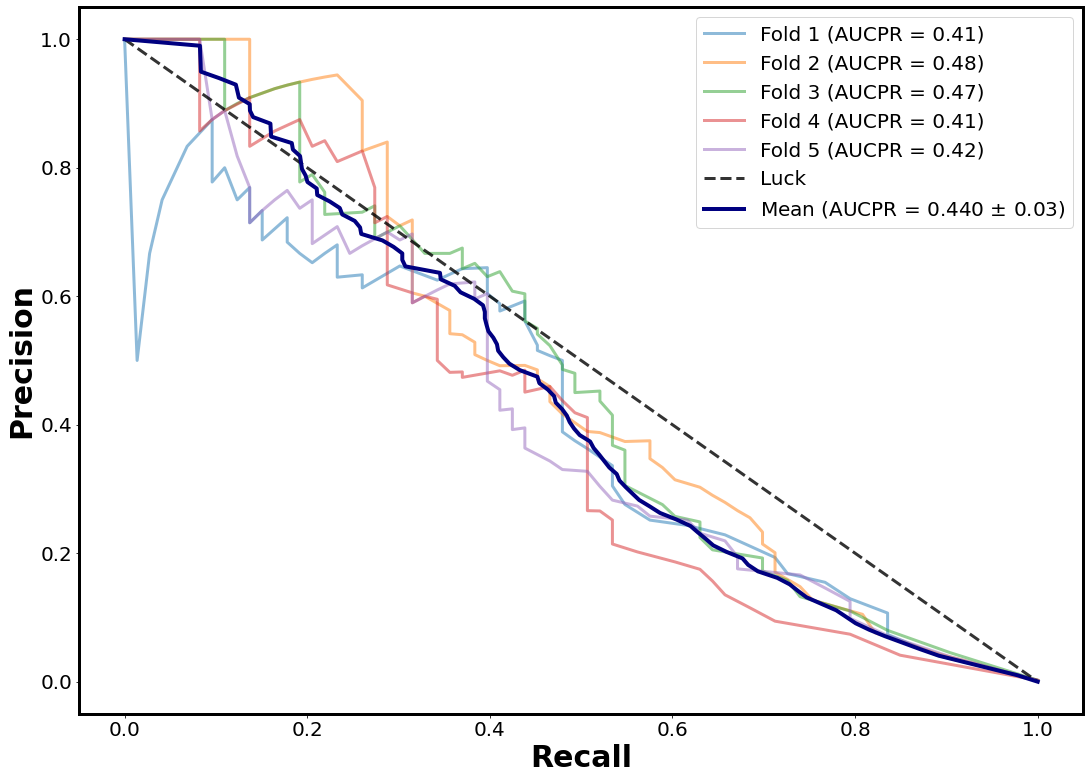

In [11]:
mpl.rcParams['axes.linewidth'] = 3 
mpl.rcParams['lines.linewidth'] = 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline

#=============================================================
# Classification and PR analysis

# defining the lists
prs = []
aucs = []
mean_recall = np.linspace(0, 1, 100)

plt.figure(figsize=(18 , 13))
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])   
    # Compute PR curve and area the curve
    precision, recall, thresholds = precision_recall_curve(y[test], probas_[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))
    i += 1
    
    y_pred = classifier.predict(X[test])
    print('P.R. AUC =', pr_auc)
    

plt.plot([0, 1], [1, 0], linestyle='--', lw=3, color='k', label='Luck', alpha=.8)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',
         label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=4)


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=30)
plt.ylabel('Precision',fontweight = "bold" , fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend( prop={'size':20} , loc = 0)

#save fig to outputs folder
save_results_to = '../images/'
plt.savefig(save_results_to + '___', dpi = 300)

plt.show()


# For each sentinel-2 imaging date, use our model to predict truck probability and counts

In [12]:
#Get a list of location images (not chipped equivalents)
date_imgs = [
        os.path.join("../data", x)
        for x in os.listdir("../data")
        if x.endswith(".tif")
        and all(keyword in x for keyword in [location])
    ]

# Get a list of dates from the images
date_list = [i[-14:-4] for i in date_imgs]
date_list.sort()

date_list

['2021-04-11', '2021-04-16', '2021-04-21']

In [13]:
# load model & scalar
with open(f'../data/trained_rf_{location}.pkl', 'rb') as f:
    rf= pickle.load(f)
with open(f'../data/scaler_{location}.pkl', 'rb') as f:
    sc=pickle.load(f)

#crate an empty csv for the results
date_count_df = pd.DataFrame([],columns=['date', 'truck_prediction_count', 'mean_truck_probability'])
date_count_df.to_csv(f"../data/{location}_truck_count&proba_results_1to10K.csv", index=False)


for d in date_list:
    
    count, proba = classify_chip_nogeos(location, d, rf, sc)
    d_res = [d, count, proba]
    date_df = pd.DataFrame([d_res], columns=['date','truck_prediction_count', 'mean_truck_probability'])
    date_df.to_csv(f"../data/{location}_truck_count&proba_results_1to10K.csv", mode='a', index=False, header=False)

The continous probability and discrete count predictions for each available sentinel-2 imaging date can now be accessed in the "../data/" folder as a ".csv" file. 